# HPDP Assignment 2: Mastering Big Data Handling
CHEN PYNG HAW


In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "pynghawchen"
os.environ['KAGGLE_KEY'] = "e7932c54737f55a09ae2db9f2ed97004"

Load and inspect data from Kaggle

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# relative path inside the dataset to load
file_path = "part-01.json"  # based on typical file names in that dataset

# Load the dataset as a pandas DataFrame
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "ebiswas/imdb-review-dataset",
    file_path
)

df.to_json("part-01.json", orient="records", lines=True)

# View basic info
print("First 5 records:\n", df.head())
print("Dataset shape:", df.shape)
print("Columns and dtypes:\n", df.dtypes)


<ipython-input-2-9b04f30c144c>:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 379M/379M [00:03<00:00, 126MB/s]

Extracting zip of part-01.json...


First 5 records:
    review_id         reviewer                          movie  rating  \
0  rw5704482    raeldor-96879            After Life (2019– )     9.0   
1  rw5704483          dosleeb  The Valhalla Murders (2019– )     6.0   
2  rw5704484  brightconscious           Special OPS (2020– )     7.0   
3  rw5704485       gasconyway              #BlackAF (2020– )     8.0   
4  rw5704487     mmason-15867             The Droving (2020)     2.0   

          review_summary review_date  spoiler_tag  \
0   Very Strong Season 2  3 May 2020            0   
1  Icelandic detectives?  3 May 2020            0   
2        Nothing special  3 May 2020            0   
3               Good but  3 May 2020            0   
4       An honest review  3 May 2020            0   

                                       review_detail   helpful  
0  I enjoyed the first season, but I must say I t...    [1, 1]  
1  I know Iceland is a small country and police d...    [2, 2]  
2  Except K K , no other actor look

## A. Comparison of Data Handling Techniques (Pandas + Dask)

1. **Load Less Data**  
In this step, we reduced the memory footprint by loading only 5 relevant columns instead of the full 9-column dataset. This helps optimize performance during initial data exploration or modeling phases where not all data is needed.

In [3]:
import pandas as pd
import time

# Select only the necessary columns to reduce memory usage
cols_to_use = ['review_id', 'reviewer', 'movie', 'rating', 'spoiler_tag']

# Measure execution time
start_time = time.time()

# Load only the selected columns
df_selected = pd.read_json("part-01.json", lines=True)[cols_to_use]

# Execution time
load_time = time.time() - start_time

# Display basic info
print("Dataset shape:", df_selected.shape)
print("First 5 records:\n", df_selected.head())

# Memory usage
mem_usage = df_selected.memory_usage(deep=True).sum() / (1024**2)  # in MB
print(f"\nMemory usage: {mem_usage:.2f} MB")
print(f"Execution time: {load_time:.2f} seconds")

Dataset shape: (1010293, 5)
First 5 records:
    review_id         reviewer                          movie  rating  \
0  rw5704482    raeldor-96879            After Life (2019– )     9.0   
1  rw5704483          dosleeb  The Valhalla Murders (2019– )     6.0   
2  rw5704484  brightconscious           Special OPS (2020– )     7.0   
3  rw5704485       gasconyway              #BlackAF (2020– )     8.0   
4  rw5704487     mmason-15867             The Droving (2020)     2.0   

   spoiler_tag  
0            0  
1            0  
2            0  
3            0  
4            0  

Memory usage: 235.14 MB
Execution time: 16.92 seconds


2. **Use Chunking**  
Chunking allows us to read large files without overloading memory. By setting a chunksize, we create an iterator that reads the file in parts. This is especially useful for preprocessing, aggregation, or transformation steps before full dataset loading.

In [4]:
import pandas as pd
import time

chunksize = 200_000
chunk_iter = pd.read_json("part-01.json", lines=True, chunksize=chunksize)

total_rows = 0
first_chunk_preview = None
first_chunk_memory = 0

# Measure execution time
start_time = time.time()

# Process chunks
for i, chunk in enumerate(chunk_iter):
    print(f"Chunk {i+1}: {chunk.shape}")
    print(chunk.head(2))
    print("-" * 50)

    total_rows += chunk.shape[0]

    # Store preview and memory usage from first chunk only
    if i == 0:
        first_chunk_preview = chunk.head()
        first_chunk_memory = chunk.memory_usage(deep=True).sum() / (1024**2)

print("Finished processing all chunks!")

# Execution time
load_time = time.time() - start_time

# Display basic info
print(f"Total rows processed: {total_rows}")
print("\nFirst 5 records from first chunk:\n", first_chunk_preview)
print(f"\nMemory usage of first chunk: {first_chunk_memory:.2f} MB")
print(f"Total execution time: {load_time:.2f} seconds")


Chunk 1: (200000, 9)
   review_id       reviewer                          movie  rating  \
0  rw5704482  raeldor-96879            After Life (2019– )     9.0   
1  rw5704483        dosleeb  The Valhalla Murders (2019– )     6.0   

          review_summary review_date  spoiler_tag  \
0   Very Strong Season 2  3 May 2020            0   
1  Icelandic detectives?  3 May 2020            0   

                                       review_detail helpful  
0  I enjoyed the first season, but I must say I t...  [1, 1]  
1  I know Iceland is a small country and police d...  [2, 2]  
--------------------------------------------------
Chunk 2: (200000, 9)
        review_id         reviewer  \
200000  rw6302053  PavithraMishra1   
200001  rw6302054        ubilstein   

                                                    movie  rating  \
200000                                  Mum Bhai (2020– )    10.0   
200001  The Walking Dead: World Beyond: The Sky Is a G...     6.0   

                     rev

3. **Optimize Data Types**  
By converting high-cardinality string columns (review_id, reviewer, movie) to category, and numeric columns to smaller types, we significantly reduce memory usage. This is vital when scaling data operations or loading multiple files.

In [5]:
import pandas as pd
import time

# Start timing
start = time.time()

# Load the dataset
df = pd.read_json("part-01.json", lines=True)

# Optimize data types during loading
df["review_id"] = df["review_id"].astype("category")
df["reviewer"] = df["reviewer"].astype("category")
df["movie"] = df["movie"].astype("category")
df["rating"] = df["rating"].astype("float32")
df["spoiler_tag"] = df["spoiler_tag"].astype("int8")
df["review_summary"] = df["review_summary"].astype("string")
df["review_detail"] = df["review_detail"].astype("string")
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

# End timing
end = time.time()

# Measure memory usage
mem_usage = df.memory_usage(deep=True).sum() / (1024**2)  # in MB

# Output
print(f"Memory usage: {mem_usage:.2f} MB")
print(f"Execution time: {end - start:.2f} seconds")
print("\nSchema:\n", df.dtypes)
print("\nSample:\n", df.head(2))


Memory usage: 1249.70 MB
Execution time: 20.66 seconds

Schema:
 review_id               category
reviewer                category
movie                   category
rating                   float32
review_summary    string[python]
review_date       datetime64[ns]
spoiler_tag                 int8
review_detail     string[python]
helpful                   object
dtype: object

Sample:
    review_id       reviewer                          movie  rating  \
0  rw5704482  raeldor-96879            After Life (2019– )     9.0   
1  rw5704483        dosleeb  The Valhalla Murders (2019– )     6.0   

          review_summary review_date  spoiler_tag  \
0   Very Strong Season 2  2020-05-03            0   
1  Icelandic detectives?  2020-05-03            0   

                                       review_detail helpful  
0  I enjoyed the first season, but I must say I t...  [1, 1]  
1  I know Iceland is a small country and police d...  [2, 2]  


4. **Sampling**  
Sampling reduces memory and compute costs during initial development. A 10% random sample (with random_state for reproducibility) provides a representative subset of the data for quicker analysis.

In [6]:
import pandas as pd
import time

# Load full dataset
df_full = pd.read_json("part-01.json", lines=True)

# Measure execution time
start_time = time.time()

# Take a 10% random sample
df_sampled = df_full.sample(frac=0.1, random_state=42)

# Execution time
load_time = time.time() - start_time

# Display basic info
print("Dataset shape:", df_sampled.shape)
print("First 5 records:\n", df_sampled.head())

# Memory usage
mem_usage = df_sampled.memory_usage(deep=True).sum() / (1024**2)  # in MB
print(f"\nMemory usage: {mem_usage:.2f} MB")
print(f"Execution time: {load_time:.2f} seconds")

Dataset shape: (101029, 9)
First 5 records:
         review_id     reviewer                     movie  rating  \
132473  rw5159986    alidortaj               Poms (2019)     8.0   
662071  rw5799756  ridi-arahan    Love and Shukla (2017)     8.0   
307447  rw5549932  SnoopyStyle      Bombshell (I) (2019)     7.0   
819809  rw2974388    agmoldham                Her (2013)     5.0   
517600  rw5580986    steveo122  Bad Boys for Life (2020)     4.0   

                                           review_summary     review_date  \
132473            Sweet, Heart Warming , and Entertaining  4 October 2019   
662071  You marry not only your spouse but spouse's fa...     5 June 2020   
307447                                   one out of three   14 March 2020   
819809          Not really sure whether I liked it or not    5 March 2014   
517600                              ...unmitigated drivel   27 March 2020   

        spoiler_tag                                      review_detail  \
132473   

5. Parallel Processing with Dask

Use Dask DataFrame to read and process large files in parallel.

In [7]:
import dask.dataframe as dd
import time

# Start timing
start = time.time()

# Load selected columns and trigger full computation
df = dd.read_json("part-01.json", lines=True, blocksize="64MB")

df_computed = df.compute()

# End timing
end = time.time()

# Basic info
n_rows = df_computed.shape[0]
n_cols = df_computed.shape[1]
head = df_computed.head()

# Memory usage
mem_mb = df_computed.memory_usage(deep=True).sum() / (1024**2)

# Output
print("First 5 records:\n", head)
print(f"Dataset shape: ({n_rows}, {n_cols})")
print(f"Memory usage: {mem_mb:.2f} MB")
print(f"Execution time: {end - start:.2f} seconds")

First 5 records:
    review_id         reviewer                          movie  rating  \
0  rw5704482    raeldor-96879            After Life (2019– )     9.0   
1  rw5704483          dosleeb  The Valhalla Murders (2019– )     6.0   
2  rw5704484  brightconscious           Special OPS (2020– )     7.0   
3  rw5704485       gasconyway              #BlackAF (2020– )     8.0   
4  rw5704487     mmason-15867             The Droving (2020)     2.0   

          review_summary review_date  spoiler_tag  \
0   Very Strong Season 2  3 May 2020            0   
1  Icelandic detectives?  3 May 2020            0   
2        Nothing special  3 May 2020            0   
3               Good but  3 May 2020            0   
4       An honest review  3 May 2020            0   

                                       review_detail       helpful  
0  I enjoyed the first season, but I must say I t...    ['1', '1']  
1  I know Iceland is a small country and police d...    ['2', '2']  
2  Except K K , no othe

## B. Normal Load Performance Across Libraries

1. Pandas

In [8]:
import pandas as pd
import time

# Measure execution time
start_time = time.time()

# Load JSON file
df = pd.read_json('part-01.json', lines=True)

# Execution time
load_time = time.time() - start_time

# Display basic info
print("Dataset shape:", df.shape)
print("First 5 records:\n", df.head())

# Memory usage
mem_usage = df.memory_usage(deep=True).sum() / (1024**2)  # in MB
print(f"\nMemory usage: {mem_usage:.2f} MB")
print(f"Execution time: {load_time:.2f} seconds")

Dataset shape: (1010293, 9)
First 5 records:
    review_id         reviewer                          movie  rating  \
0  rw5704482    raeldor-96879            After Life (2019– )     9.0   
1  rw5704483          dosleeb  The Valhalla Murders (2019– )     6.0   
2  rw5704484  brightconscious           Special OPS (2020– )     7.0   
3  rw5704485       gasconyway              #BlackAF (2020– )     8.0   
4  rw5704487     mmason-15867             The Droving (2020)     2.0   

          review_summary review_date  spoiler_tag  \
0   Very Strong Season 2  3 May 2020            0   
1  Icelandic detectives?  3 May 2020            0   
2        Nothing special  3 May 2020            0   
3               Good but  3 May 2020            0   
4       An honest review  3 May 2020            0   

                                       review_detail   helpful  
0  I enjoyed the first season, but I must say I t...    [1, 1]  
1  I know Iceland is a small country and police d...    [2, 2]  
2  Exce

2. Polars

In [9]:
import polars as pl
import time

# Measure time
start = time.time()

# Load only selected columns
df_polars = pl.read_ndjson("part-01.json")

end = time.time()

# Show basic info
print(df_polars.head(5))
print("Shape:", df_polars.shape)
print(f"Execution Time: {end - start:.2f} seconds")
print(f"Memory usage: {df_polars.estimated_size('mb'):.2f} MB")

shape: (5, 9)
┌───────────┬────────────┬────────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id ┆ reviewer   ┆ movie      ┆ rating ┆ … ┆ review_da ┆ spoiler_t ┆ review_de ┆ helpful   │
│ ---       ┆ ---        ┆ ---        ┆ ---    ┆   ┆ te        ┆ ag        ┆ tail      ┆ ---       │
│ str       ┆ str        ┆ str        ┆ f64    ┆   ┆ ---       ┆ ---       ┆ ---       ┆ list[str] │
│           ┆            ┆            ┆        ┆   ┆ str       ┆ i64       ┆ str       ┆           │
╞═══════════╪════════════╪════════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ rw5704482 ┆ raeldor-96 ┆ After Life ┆ 9.0    ┆ … ┆ 3 May     ┆ 0         ┆ I enjoyed ┆ ["1",     │
│           ┆ 879        ┆ (2019– )   ┆        ┆   ┆ 2020      ┆           ┆ the first ┆ "1"]      │
│           ┆            ┆            ┆        ┆   ┆           ┆           ┆ season,   ┆           │
│           ┆            ┆            ┆        ┆   ┆           ┆           ┆ 

3. Dask

In [10]:
import dask.dataframe as dd
import time

# Start timing
start = time.time()

# Load selected columns and trigger full computation
df = dd.read_json("part-01.json", lines=True, blocksize="64MB")

df_computed = df.compute()

# End timing
end = time.time()

# Basic info
n_rows = df_computed.shape[0]
n_cols = df_computed.shape[1]
head = df_computed.head()

# Memory usage
mem_mb = df_computed.memory_usage(deep=True).sum() / (1024**2)

# Output
print("First 5 records:\n", head)
print(f"Dataset shape: ({n_rows}, {n_cols})")
print(f"Memory usage: {mem_mb:.2f} MB")
print(f"Execution time: {end - start:.2f} seconds")

First 5 records:
    review_id         reviewer                          movie  rating  \
0  rw5704482    raeldor-96879            After Life (2019– )     9.0   
1  rw5704483          dosleeb  The Valhalla Murders (2019– )     6.0   
2  rw5704484  brightconscious           Special OPS (2020– )     7.0   
3  rw5704485       gasconyway              #BlackAF (2020– )     8.0   
4  rw5704487     mmason-15867             The Droving (2020)     2.0   

          review_summary review_date  spoiler_tag  \
0   Very Strong Season 2  3 May 2020            0   
1  Icelandic detectives?  3 May 2020            0   
2        Nothing special  3 May 2020            0   
3               Good but  3 May 2020            0   
4       An honest review  3 May 2020            0   

                                       review_detail       helpful  
0  I enjoyed the first season, but I must say I t...    ['1', '1']  
1  I know Iceland is a small country and police d...    ['2', '2']  
2  Except K K , no othe

## C. Comparative Analysis

###📊 Part 1: Comparison of Data Handling Techniques (Pandas + Dask)

This section visualizes the performance of five data handling strategies applied to a large dataset. The first four strategies—Load Less Data, Use Chunking, Optimize Data Types, and Sampling—are implemented using Pandas, while the fifth strategy—Parallel Processing with Dask—uses Dask with normal loading.   

Two bar charts are generated:

1. One compares the execution time (in seconds).

2. The other compares the memory usage (in MB).

This analysis helps identify which technique offers the best trade-off between speed and memory efficiency when using traditional vs. parallelized approaches.

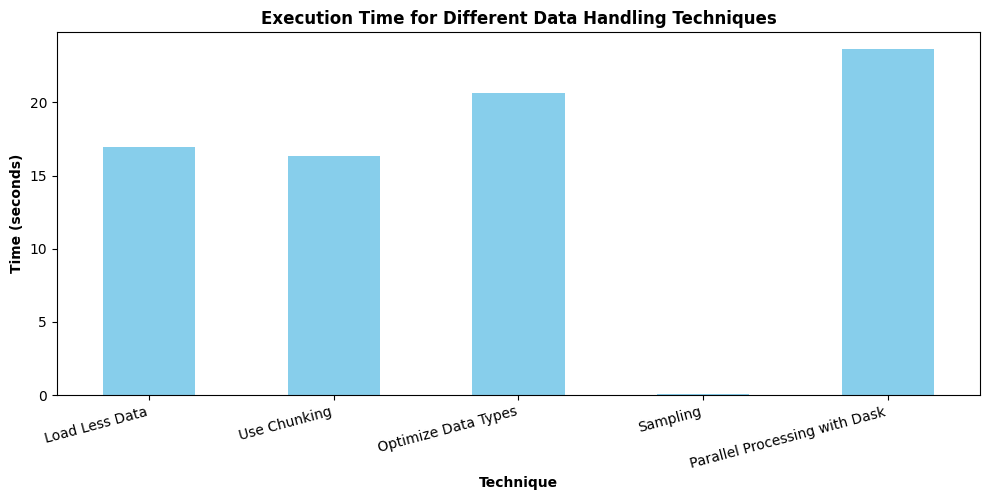

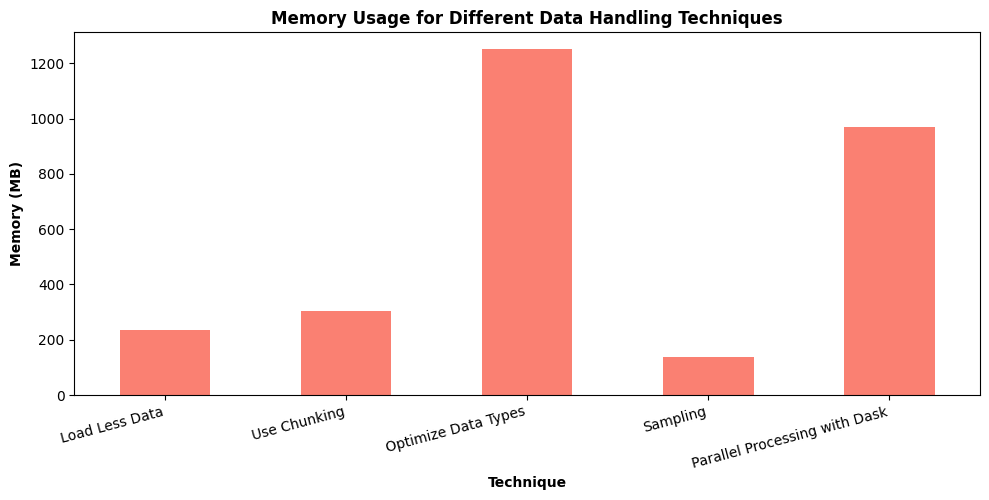

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Define comparison data
techniques = [
    "Load Less Data",
    "Use Chunking",
    "Optimize Data Types",
    "Sampling",
    "Parallel Processing with Dask"
]

execution_time = [
    16.92,   # Pandas: Load Less Data
    16.37,   # Pandas: Use Chunking
    20.66,   # Pandas: Optimize Data Types
    0.07,    # Pandas: Sampling
    23.62    # Dask: Normal Load as Parallel
]

memory_usage = [
    235.14,  # Pandas: Load Less Data
    301.95,  # Pandas: Use Chunking
    1249.7,  # Pandas: Optimize Data Types
    138.07,  # Pandas: Sampling
    967.74   # Dask: Normal Load as Parallel
]

# Create DataFrames
df_comparison = pd.DataFrame({
    "Technique": techniques,
    "Execution Time (s)": execution_time,
    "Memory Usage (MB)": memory_usage
}).set_index("Technique")

# Plot execution time
fig1, ax1 = plt.subplots(figsize=(10, 5))
df_comparison["Execution Time (s)"].plot(kind="bar", ax=ax1, color='skyblue')
ax1.set_title("Execution Time for Different Data Handling Techniques", fontweight='bold')
ax1.set_ylabel("Time (seconds)", fontweight='bold')
ax1.set_xlabel("Technique", fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Plot memory usage
fig2, ax2 = plt.subplots(figsize=(10, 5))
df_comparison["Memory Usage (MB)"].plot(kind="bar", ax=ax2, color='salmon')
ax2.set_title("Memory Usage for Different Data Handling Techniques", fontweight='bold')
ax2.set_ylabel("Memory (MB)", fontweight='bold')
ax2.set_xlabel("Technique", fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()


#### Ease of Processing
From a usability perspective, Pandas offers a very intuitive and beginner-friendly interface for implementing strategies like Load Less Data, Chunking, Type Optimization, and Sampling. These methods require only minor adjustments to the typical Pandas workflow, such as:

- Adding a usecols parameter for column filtering,

- Iterating over read_csv(..., chunksize=...),

- Converting data types with .astype() or pd.to_numeric(),

- Applying .sample() for downsampling.

However, Dask—used here as the parallel processing tool—has a slightly steeper learning curve. It requires understanding of lazy evaluation and compute() calls to trigger actual operations. While it closely mimics the Pandas API, users need to be more deliberate with operations due to Dask's deferred execution model.

In summary:

- Pandas techniques are easier to apply and debug for most users.

- Dask provides power and scalability but requires more care in planning and execution, especially when chaining transformations.

### 📊 Part 2: Normal Load Performance Across Libraries

In this comparison, the dataset is loaded normally (without optimization) using three different libraries: Pandas, Polars, and Dask. The two resulting bar charts show:

1. The execution time taken by each library to load the full dataset.

2. The memory consumed during the loading process.

This highlights the baseline efficiency of each library, helping to inform which tool might be the most suitable for large-scale data handling in its default configuration.

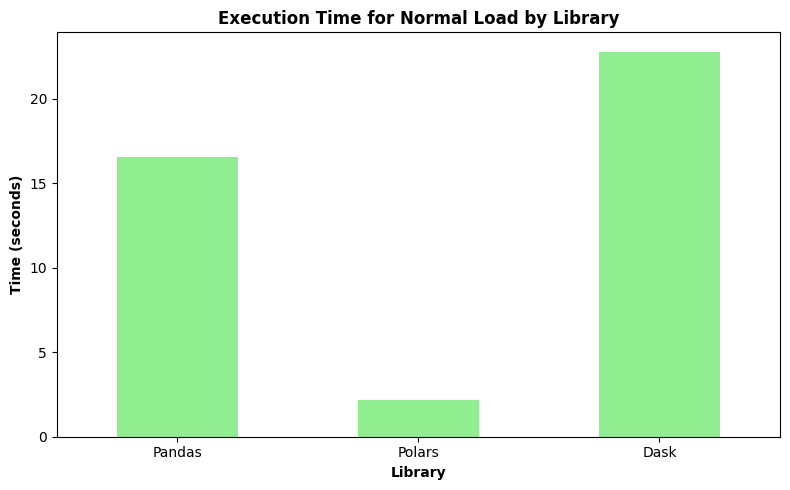

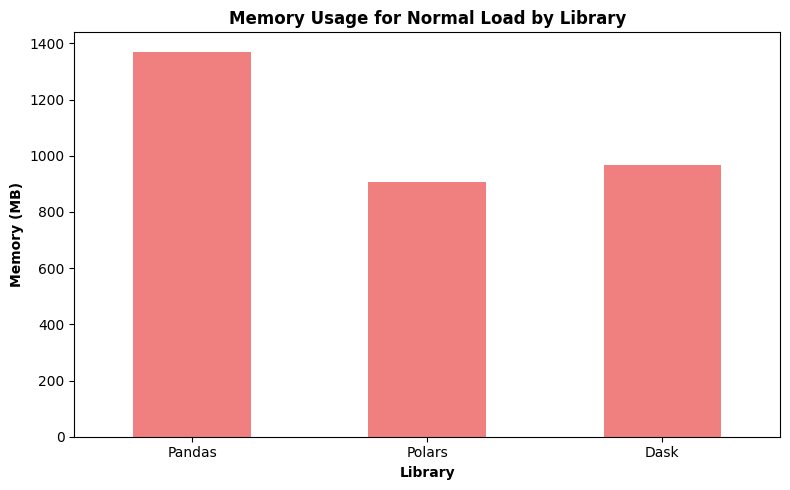

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for normal load across libraries
libraries = ["Pandas", "Polars", "Dask"]

execution_time = [16.52, 2.19, 22.78]
memory_usage = [1370.75, 906.2, 967.74]

# Create DataFrame
df_normal_load = pd.DataFrame({
    "Library": libraries,
    "Execution Time (s)": execution_time,
    "Memory Usage (MB)": memory_usage
}).set_index("Library")

# Plot execution time
fig1, ax1 = plt.subplots(figsize=(8, 5))
df_normal_load["Execution Time (s)"].plot(kind="bar", ax=ax1, color='lightgreen')
ax1.set_title("Execution Time for Normal Load by Library", fontweight='bold')
ax1.set_ylabel("Time (seconds)", fontweight='bold')
ax1.set_xlabel("Library", fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()

# Plot memory usage
fig2, ax2 = plt.subplots(figsize=(8, 5))
df_normal_load["Memory Usage (MB)"].plot(kind="bar", ax=ax2, color='lightcoral')
ax2.set_title("Memory Usage for Normal Load by Library", fontweight='bold')
ax2.set_ylabel("Memory (MB)", fontweight='bold')
ax2.set_xlabel("Library", fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

#### Ease of Processing
Loading data normally with Pandas is straightforward and well-documented. It has the broadest community support and the most mature ecosystem, making it the easiest for most users.

Polars, on the other hand, is newer but optimized for speed and memory. While it uses a different syntax based on expressions and lazy evaluation, its documentation is growing, and once familiar, it can be just as productive. It may take a little more effort initially for those coming from a Pandas background.

Dask, as previously noted, introduces complexity due to lazy execution and the need to explicitly compute() results. For normal loading, it is still simple, but integrating it into more complex workflows requires deeper knowledge of task graphs and memory partitions.

In summary:

- Pandas is easiest for direct use and familiarity.

- Polars is fast but slightly different in syntax, requiring adaptation.

- Dask is the most scalable but requires the most care in design.